# 0. Import modules

In [1]:
## execute to install modules if you dont have them 

#!pip install tensorflow
#!pip install pandas
#!pip install numpy
#!pip install opencv-python

In [2]:
# ML / DS libraries
import pandas as pd
import tensorflow as tf
import numpy as np


# For the model
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Dropout, Flatten
from tensorflow.keras.metrics import CategoricalAccuracy, FalseNegatives, FalsePositives
from tensorflow.keras.callbacks import ModelCheckpoint


# visualizers
import matplotlib.pyplot as plt
import seaborn as sns


# image processing
from PIL import Image
import cv2


import sys
import os
import re

In [3]:
# Pandas specific settings

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

**Dependencies info**

In [54]:
# Dependencies info of main modules (Do not re-execute otherwise will be override)
print(f"Versions:\nPython: {sys.version.split(' ')[0]}\nPandas: {pd.__version__}\nTensorflow: {tf.__version__}\nNumpy: {np.__version__}")

Versions:
Python: 3.6.12
Pandas: 1.1.1
Tensorflow: 2.2.0
Numpy: 1.19.1


**Working directory**

In [1]:
#os.getcwd()

In [2]:
# List of files in the directory
#os.listdir()

### Assumptions:
* i'm assuming that the final model will be used on images similar to the images given for training and testing. This means if the given images have been preprocessed (centered, no rotation, etc.) then the model should only be used to predict images with similar contitions.

# 1. Import the dataset

#### For 2D images

In [8]:

def summarize_folder(path):
    '''
    This function walks the image directory and return the image path, its class and id
    param path: (str) The path to the folder
    output: (DataFrame) a dataframe containing the path, ID and class of each image within the directory
    '''
    
    # Each entry will be added here
    ids, classes, paths = [], [], []
    
    # walking directory
    for file in os.listdir(path):
        # Getting id and class from file name
        id_, class_ = re.findall(r"[0-9]+", file)
        
        # add ID, Class and file path to the lists
        ids.append(int(id_)); classes.append(int(class_)); paths.append(file)
    
    # return a dataframe from the lists
    return pd.DataFrame({'id': ids,
                         'class': classes,
                         'path': [path+d for d in os.listdir(path)]})

def imread(path):
    '''
    A simple function used to load an image and return an ndarray
    param path: (str) the image file path
    output: (ndArray) The loaded image
    '''
    return np.asarray(Image.open(path))

In [9]:
# Constructing a dataframe for both train and test image folders

train_df = summarize_folder('Train Images 13440x32x32/train/')
test_df = summarize_folder('Test Images 3360x32x32/Test/')

In [10]:
# How Train dataframe is looking
train_df.head(2)

,id,class,path
0,10000,18,Train Images 13440x32x32/train/id_10000_label_18.png
1,10001,19,Train Images 13440x32x32/train/id_10001_label_19.png


In [11]:
# How Test dataframe is looking
test_df.head(2)

,id,class,path
0,1000,24,Test Images 3360x32x32/Test/id_1000_label_24.png
1,1001,25,Test Images 3360x32x32/Test/id_1001_label_25.png


#### Sanity checks

In [12]:
# Below is some sanity checks to ensure everything is loaded properly

test1 = not False in np.sort(test_df['class'].unique()) == np.sort(train_df['class'].unique())
test2 = test_df['class'].nunique() == train_df['class'].nunique() == 28

test3 = train_df.shape[0] == 13440
test4 = test_df.shape[0] == 3360

# Green Pass
good = "\033[92m PASS \033[0m"
# Red Failed
bad = "\033[91m FAILED \033[0m"


print(f"Train and Test sets contain the same unique labels\t{good if test1 else bad}")
print(f"Number of unique labels is 28:\t{good if test2 else bad}")
print(f"Length of Train and Test sets match specification:\t{good if test3 else bad}, {good if test4 else bad}")

Train and Test sets contain the same unique labels	 PASS 
Number of unique labels is 28:	 PASS 
Length of Train and Test sets match specification:	 PASS ,  PASS 


# 2. Explore the data and visualize significant variables (EDA).
#### Checking the distribution of the classes
Below, i will check the counts of entries for each class for both train and test, this gives me an idea whether the datasets are balanced.

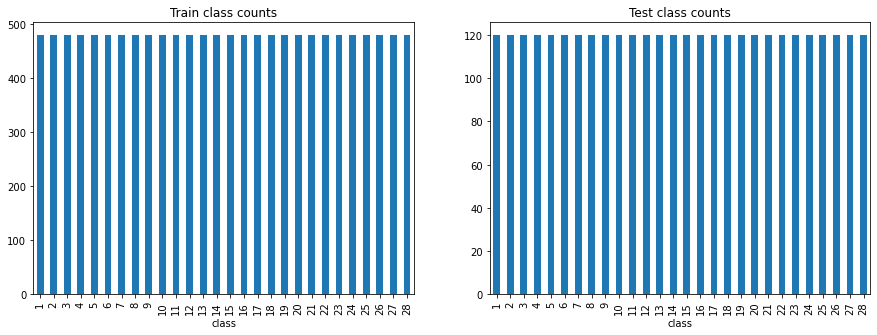

In [13]:

fig = plt.figure(figsize=(15,5))

# making a subplot which contains the count of rows grouped by class for train set
ax1 = fig.add_subplot(1,2,1)
train_df.groupby('class')['class'].count().plot(kind='bar', ax=ax1)
ax1.set_title('Train class counts')

# making a subplot which contains the count of rows grouped by class for test set
ax2 = fig.add_subplot(1,2,2)
test_df.groupby('class')['class'].count().plot(kind='bar', ax=ax2)
ax2.set_title('Test class counts')
plt.show()

Thankfully, all the classess are already balanced. Next step is to check if there are any entries with missing values

In [14]:
# Total number of rows - total number of rows containing empty values

print(f"TRAIN SET: Number of rows containing empty values: {train_df.shape[0]-train_df.dropna().shape[0]}")
print(f"TEST SET: Number of rows containing empty values: {test_df.shape[0]-test_df.dropna().shape[0]}")

TRAIN SET: Number of rows containing empty values: 0
TEST SET: Number of rows containing empty values: 0


There are no rows containing empty values.

Next, i'm going to take a sample image of each class and plot a histogram

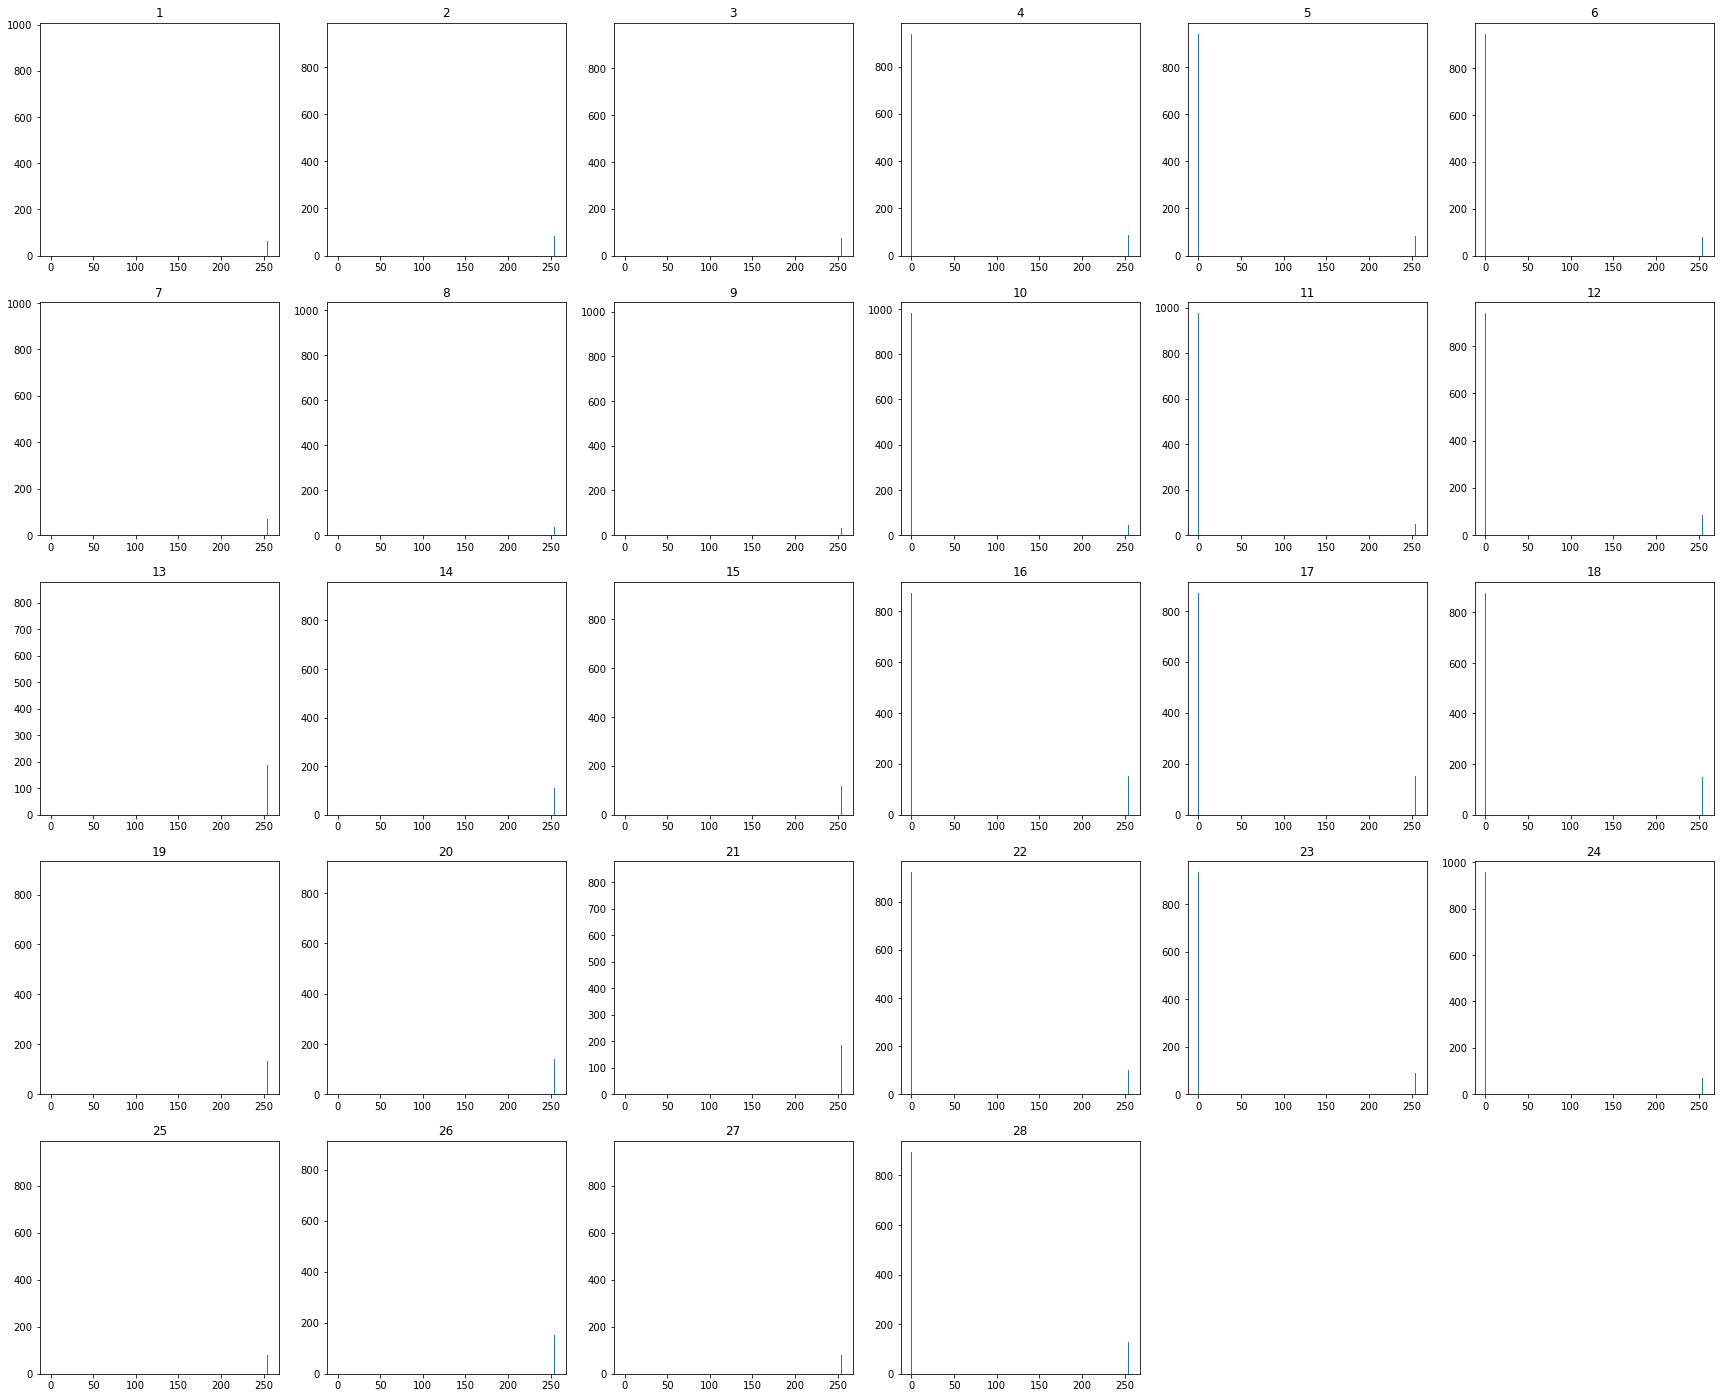

In [15]:
#Plotting the histogram of a sample of each class

fig = plt.figure(figsize=(30,30))

# for each class
for group_name, df in train_df.groupby('class'):
    
    # create a separate subplot
    ax = fig.add_subplot(6,6,group_name)
    
    # load the image then plot a histogram
    ax.hist(imread(df.path.iloc[10]).ravel(), bins=256)
    
    # class number as title
    ax.set_title(str(group_name))

From the histograms above, the images appear to already have been binarized (pixel value can take either 0 or 255). The range will be adjusted when constructing the preprocessing method to (0 - 1)

### Printing out a sample of each class
Below, i will will visualize a sample from each class 

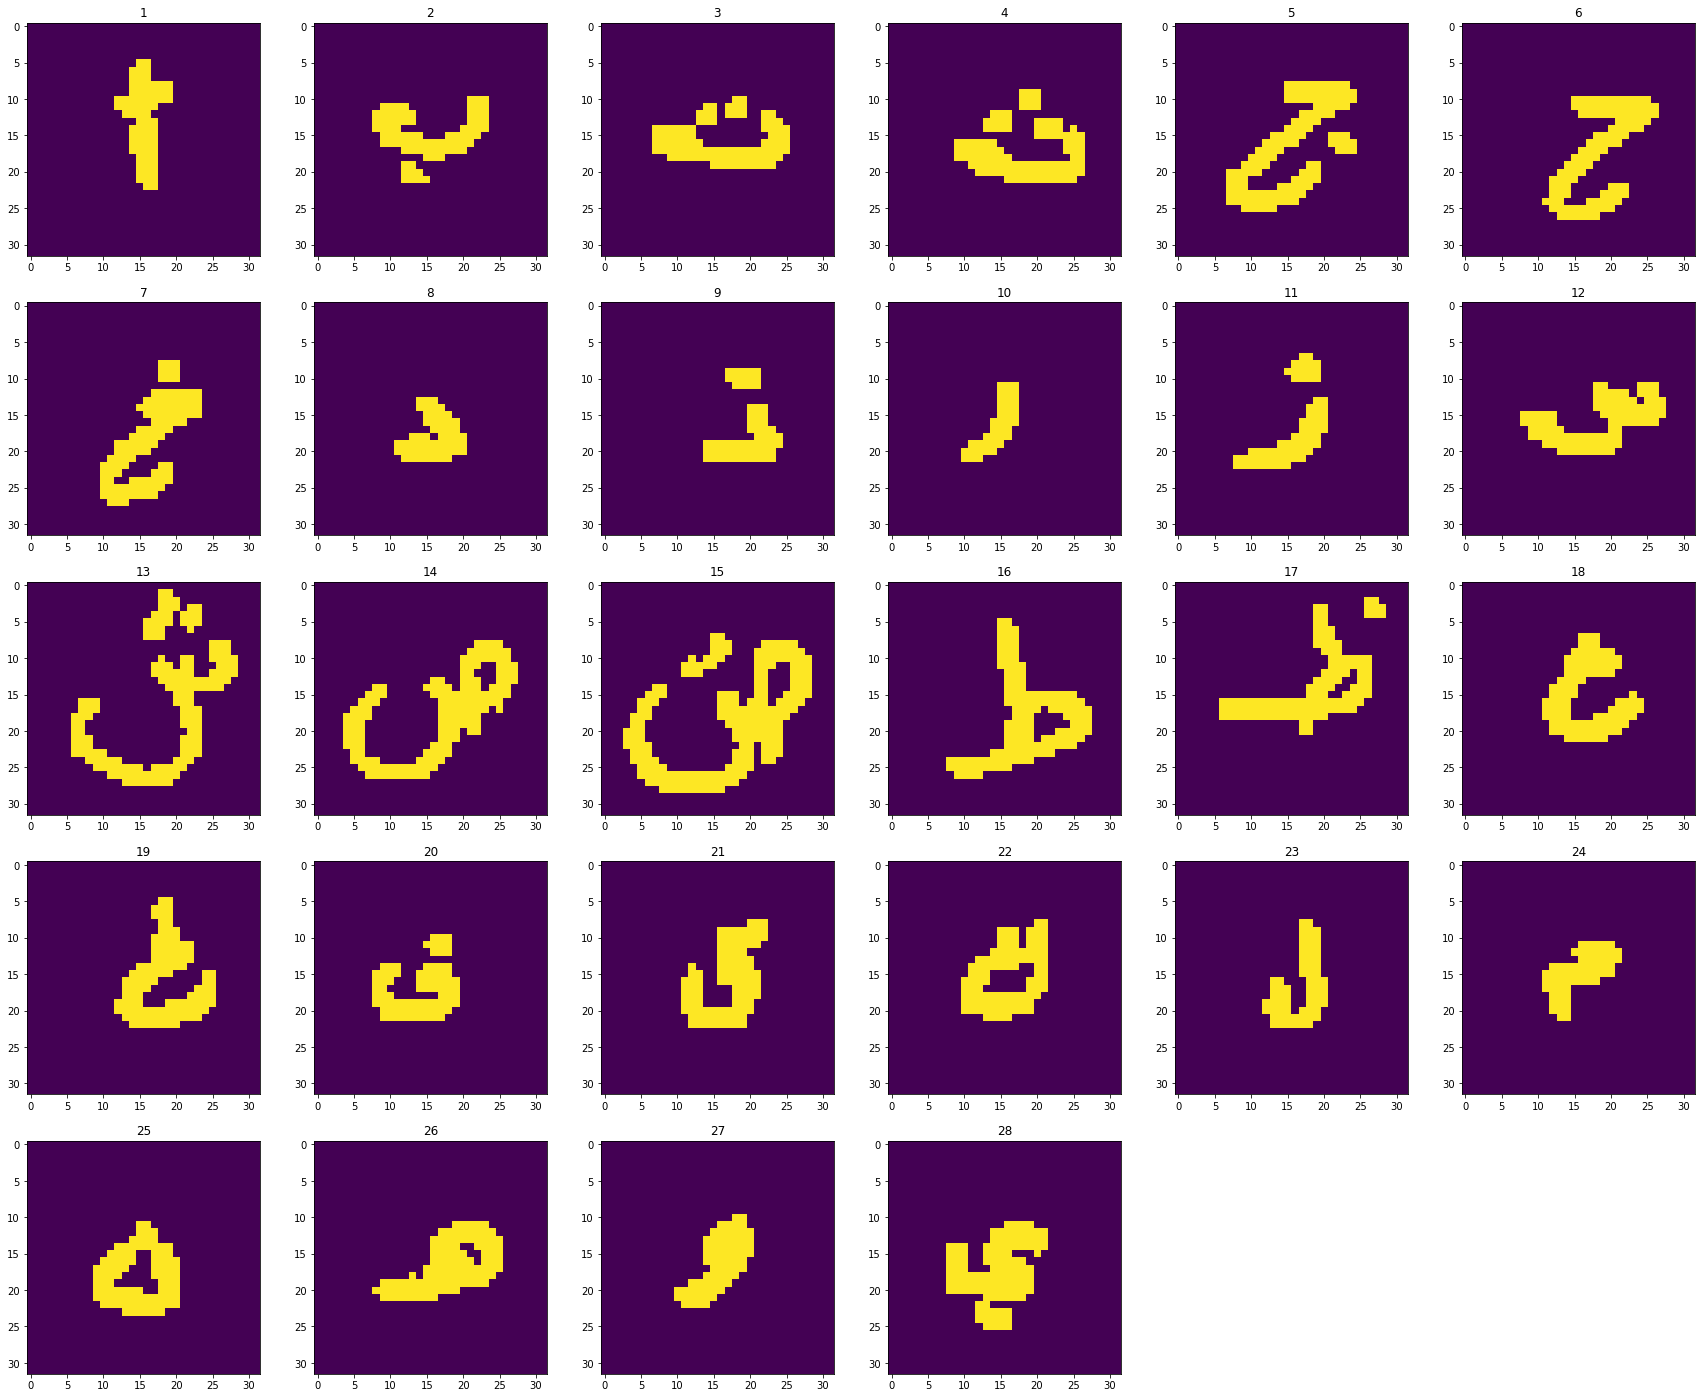

In [16]:
fig = plt.figure(figsize=(30,30))

# for each class
for group_name, df in train_df.groupby('class'):
    
    # create a subplot, then load the image and display it
    ax = fig.add_subplot(6,6,group_name)
    ax.imshow(Image.open(df.path.iloc[0]))
    ax.set_title(str(group_name))

Above is a visualization for each of the classes. from the images, it seems to be a good idea to apply some morphological operations. The main purpose of this is to attempt to seperate dots from the the body of the character in examples such as below ![image of a character with connected dots to body](imgs/thaa.png).

After trying Opening, Closing and Erosion, the best operation which achieves optimal result is erosion. Hence, below i will visualize the same set of samples visualized above, after applying erosion



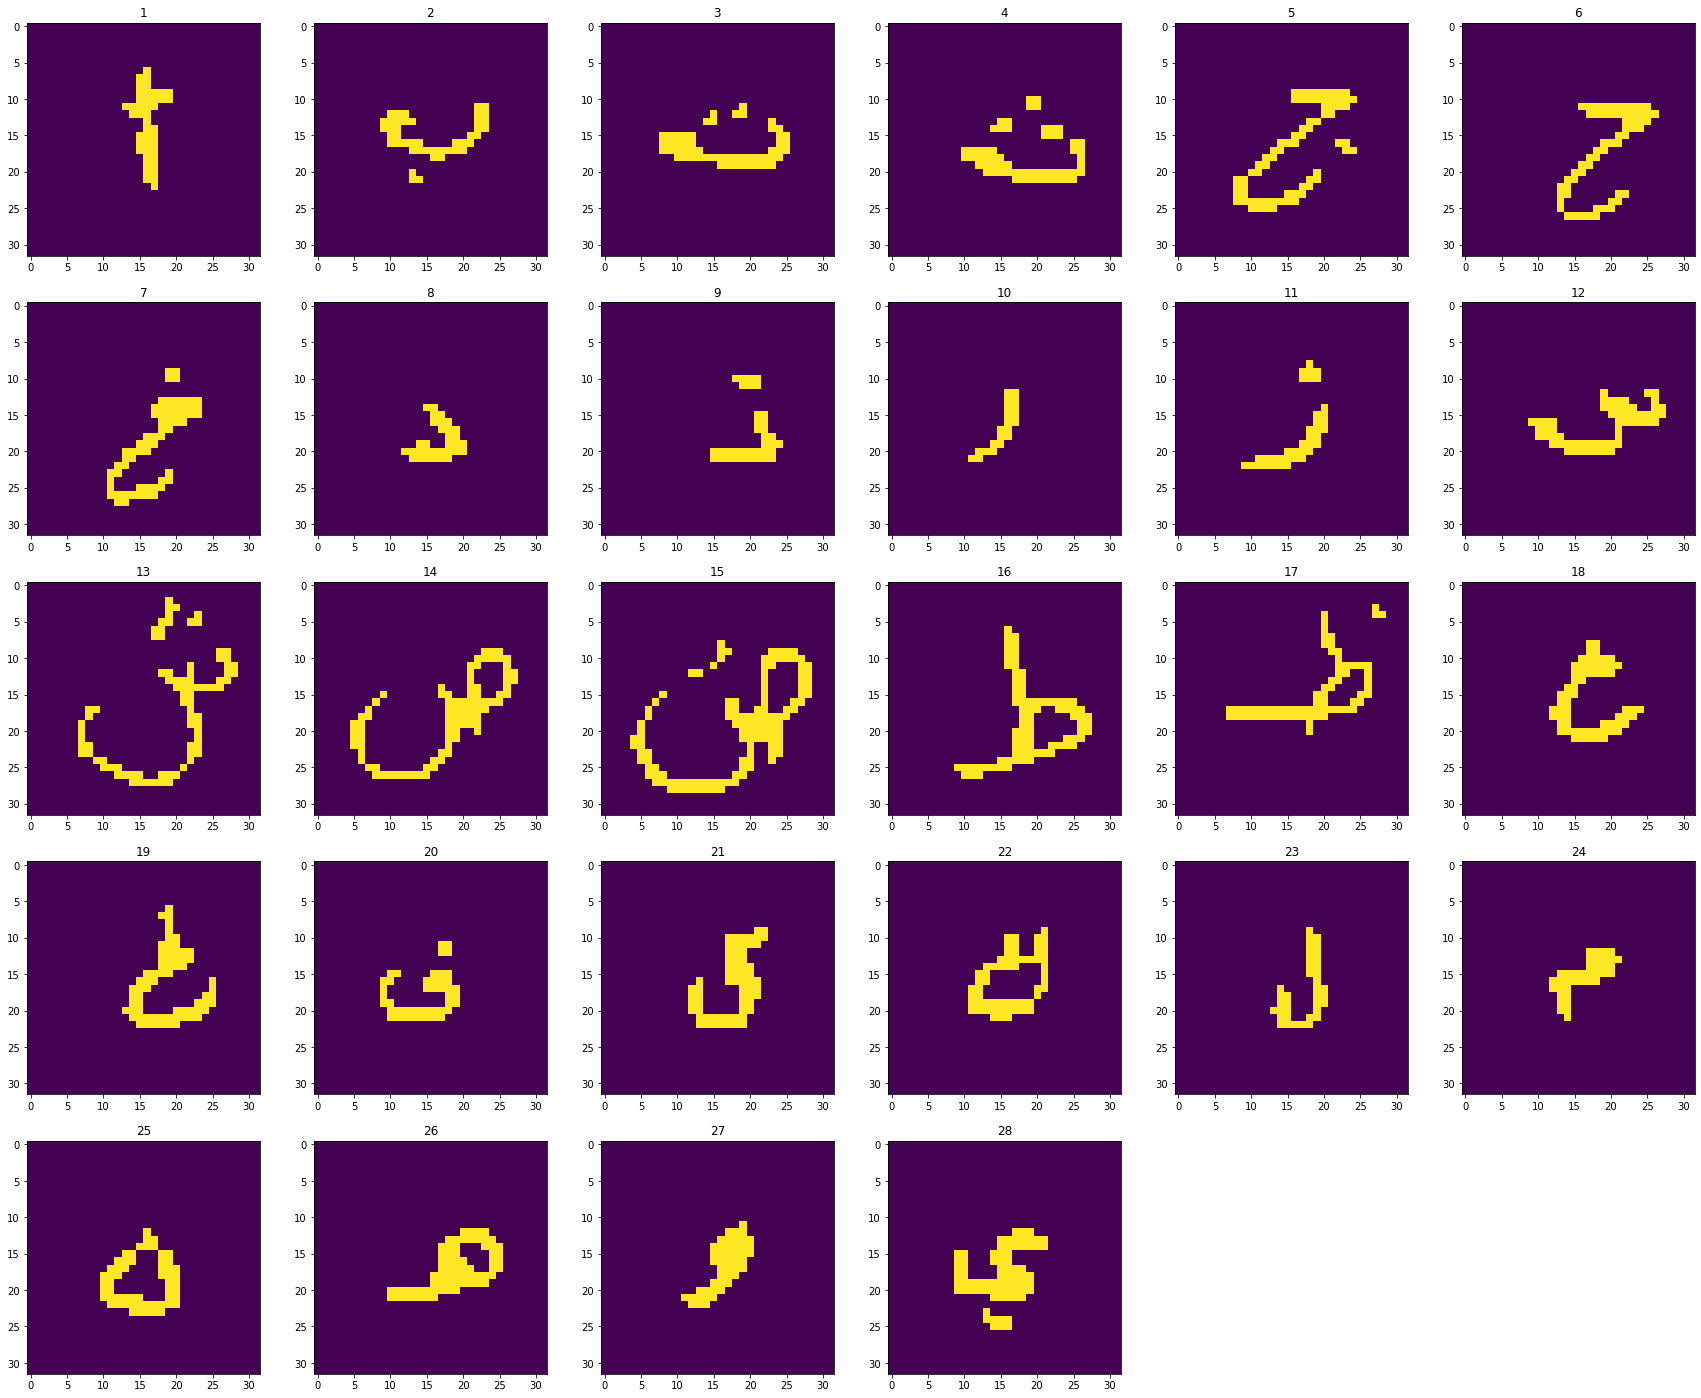

In [17]:
# kernel for erosion (will erode any misses and keeps the hits)
kernel = np.ones((2,2),dtype='uint8')

fig = plt.figure(figsize=(30,30))
# for each class
for group_name, df in train_df.groupby('class'):
    
    # show image after erosion
    ax = fig.add_subplot(6,6,group_name)
    ax.imshow(cv2.erode(imread(df.path.iloc[0]), kernel))
    ax.set_title(str(group_name))

After applying erosion with a square mask of 2x2, some dots apear clearer ( good distance from the body of the character). However, the thickness of the character is reduce and some dots are still connected. If the images were larger, a more detailed masks could have been used which will perform better. for now, i will erode training and testing set in the next section.

Below is a sample "before and after of one of class 28 (ي)

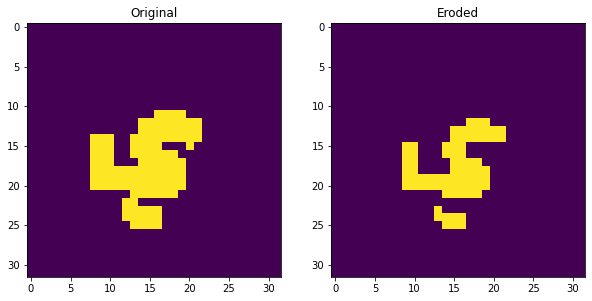

In [18]:
# reading an image 
im = imread(df.path.iloc[0])

# erode the image using a 2x2 square kernel
c = cv2.erode(im, kernel)

# displaying a comparison
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(im)
ax1.set_title('Original')

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(cv2.erode(imread(df.path.iloc[0]), kernel))
ax2.set_title('Eroded')
plt.show()

### Visualizing the variation within each class
When it comes to handwriting, there are many factors that affect how a person writes a character. Hence, below i will visualize the variation within each class to have a better idea whether spatial information will benefit us during modeling and to have a rough idea about the pattern which the model might focuse on to classify each class.

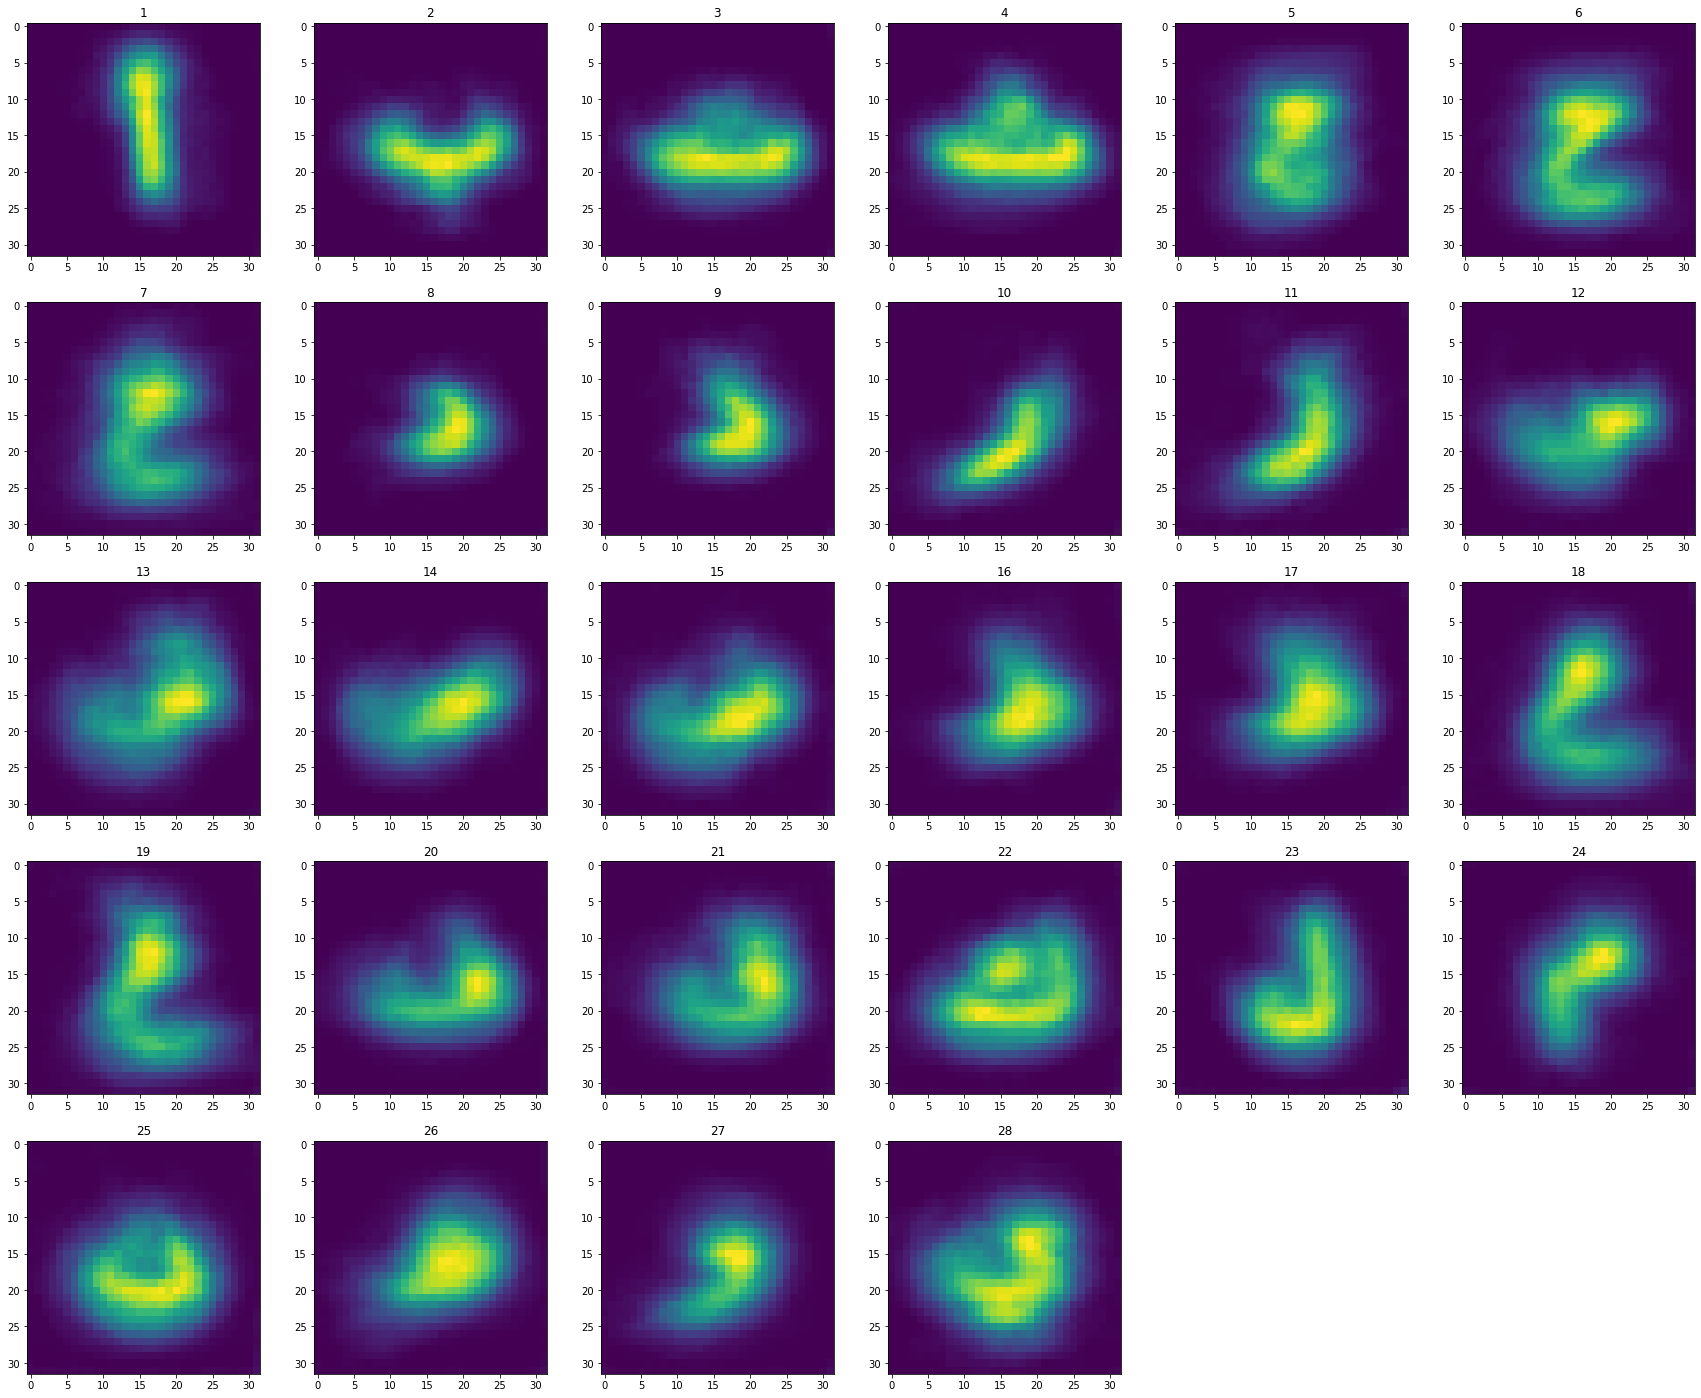

In [19]:

fig = plt.figure(figsize=(30,30))

# for each class
for group_name, df in train_df.groupby('class'):
    
    # read all the images in the class and add it to an array
    avg_img = np.array([imread(p) for p in df.path.tolist()])
    
    # get the average intensity of each pixel 
    avg_img = avg_img.mean(axis=0)
    
    # show the averaged image
    ax = fig.add_subplot(6,6,group_name)
    ax.imshow(avg_img)
    ax.set_title(str(group_name))


Based on the images above, the characters are centered which means spatial information near the border will not play a roll in enhancing performance. However, if we looked at the character, there are variations in typing them, and this variation gets severe with complex characters such س and ش (label 12, 13). As it can be seen from the two characters mentioned previously, people tend to agree on the way they draw the head of these 2 characters (indicated as bright yellow), while drastically differ on how they draw the tail (indicated by dark green to blue hue). I believe due to this, leveraging spatial information will be a good idea in enhancing performance.

Furthermore, there seems to be a distinctive patterns (bright yellow) between the classes and i'm looking forward to see how a convolutional neural network will handle such data


# 4. Data Prepping for Modeling

Instead of driving new variables, i will modify a custom data generator to handle preprocessing of batches in real-time ( Although there is not much benefit with this dataset since the images are small and could be all loaded to memory with no issues, it is a good practice when dealing with large images dataset as it only loads images for the specified batch and apply preprocessing before it gets passed to the model)

In [20]:
class DataGen(tf.keras.utils.Sequence):
    '''
    A custom sequence to pre-process data on the go based on the steps mentioned in the sections above.
    param df: (DataFrame) a pandas dataframe containing all the data
    param x_col: (str) name of the image path column
    param y_col: (str) name of the label column
    param batch_size: (int) the number of images per batch
    param suffle: (bool) whether to suffle the data after each epoch
    param kernel: (ndArray) a kernel used when applying erosion 
    param erode: (bool) whether to apply erosion after laoding images
    output: (Tuple) a tuple of (X,y) which contains preprocessed images and labels
    '''
    def __init__(self, df, x_col, y_col, batch_size=32, shuffle=True, kernel=None, erode=True):
        
        # adding params to class
        self.batch_size = batch_size
        self.x_col = x_col
        self.y_col = y_col
        self.erode_img = erode
        self.shuffle = shuffle
        
        # copying to prevent any modifications on main df
        self.df = df.copy()
        self.indices = self.df.index.tolist()
        
        # labels will be a one hot encoded dataframe
        self.labels = pd.get_dummies(self.df.pop(self.y_col))
        
        # if user didnt specify a kernel, use a 2x2 square
        self.kernel = np.ones((2,2),dtype='uint8') if kernel is None else kernel
        
        # get the image dimensions from a sample within the dataframe
        self.img_size = self.imread(self.df[self.x_col].iloc[1]).shape
        
        
        self.on_epoch_end()

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        # construct a list of idexes of the current batch
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[i] for i in index]
        
        # preprocess
        X, y = self.__get_data(batch)
        return X, y

    def on_epoch_end(self):
        # suffle indexes at the end of the epoch if user specified
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)
            
    def imread(self, path):
        # read image as ndArray
        return np.asarray(Image.open(path))
    
    
    def erode(self, img):
        # return an eroded image if user specified else, return the original image
        return cv2.erode(self.imread(img), self.kernel) if self.erode_img else self.imread(img)
        
    def __get_data(self, batch):
        
        # load and preprocess each image in the current batch, then reshape X to be (batch_size,img_dim1,img_dim2,img_dim3)
        X = np.array([self.erode(img_path)/255. for img_path in self.df[self.x_col].iloc[batch].tolist()]).reshape(self.batch_size,*self.img_size,1)
        
        # get an array of labels for the current batch
        y = self.labels.iloc[batch].to_numpy()
        return X, y

Since i'm planning to use deep learning models, i'm trying to maximize the training set, hence, i will pull a small validation set from the test dataframe. Since there are 120 samples of each class as seen in the EDA section, i will pull a random 40 samples from each class for validation

In [21]:
def validation_test_split(whole_df, y='class'):
    
    # shuffle the dataset
    whole_df = whole_df.sample(frac=1).reset_index(drop=True)
    
    # indexes of rows will be stored here
    test_idx, val_idx = [], []
    
    # for each class
    for g_name, df in whole_df.groupby(y):
        
        # add the index of the first 20 rows to validation
        val_idx += df.index.values[:40].tolist()
        
        # add the rest to test
        test_idx += df.index.values[40:].tolist()
        
    # return new validation dataframe and test dataframe
    return whole_df.copy().iloc[val_idx].reset_index(drop=True), whole_df.copy().iloc[test_idx].reset_index(drop=True)

In [22]:

# using the above function to split the test set to validation and test
val_df, test_df = validation_test_split(test_df)

# 7. Mention the type of modelling that is suitable for the problem and describe your criteria for the selection (Decision Tree, linear regression or Deep learning, etc.)

The points below impacted the decision making process:
* The dimension is sparse
* There is a noticable amount of noise within each class as can be seen from the "Visualizing the variation within each class" 
* Spatial information could be leveraged to enhance results 

I have decided to use deep learning models
* Will create 2 CNNs (one trains on Eroded images, the other on non-eroded images)
* will create 1 MLP (compare results with CNN to see whether i was right about spatial info) 

In [23]:
BATCH_SIZE = 64
N_CLASSES = train_df['class'].nunique()
INPUT_SHAPE = (*imread(train_df['path'].iloc[0]).shape,1)
EPOCHS = 20
METRICS = [CategoricalAccuracy()]#,FalseNegatives(),FalsePositives()]


train_eroded_gen = DataGen(train_df, 'path', 'class', batch_size=BATCH_SIZE)
val_eroded_gen = DataGen(val_df, 'path', 'class', batch_size=BATCH_SIZE)


train_gen = DataGen(train_df, 'path', 'class', batch_size=BATCH_SIZE, erode=False)
val_gen = DataGen(val_df, 'path', 'class', batch_size=BATCH_SIZE, erode=False)



In [24]:
# Building a model to be trained on eroded data
er_cnn_model = tf.keras.Sequential()
er_cnn_model.add(Conv2D(64, (5,5),input_shape=INPUT_SHAPE, activation='relu'))


er_cnn_model.add(Conv2D(64, (5,5), activation='relu'))
#er_cnn_model.add(BatchNormalization())

er_cnn_model.add(Flatten())

er_cnn_model.add(Dense(124, activation='relu'))
er_cnn_model.add(Dropout(0.3))

er_cnn_model.add(Dense(32, activation='relu', kernel_regularizer ='l2'))
er_cnn_model.add(Dropout(0.3))

er_cnn_model.add(Dense(N_CLASSES, activation='softmax'))




er_cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)
er_cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        102464    
_________________________________________________________________
flatten (Flatten)            (None, 36864)             0         
_________________________________________________________________
dense (Dense)                (None, 124)               4571260   
_________________________________________________________________
dropout (Dropout)            (None, 124)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4000      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0

In [25]:
cb = ModelCheckpoint(
    filepath="erode_cnn_model_weights.h5",
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

erode_cnn_history = er_cnn_model.fit(train_eroded_gen, validation_data=val_eroded_gen, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[cb])

Epoch 1/20
210/210 [==============================] - 48s 228ms/step - loss: 2.8307 - categorical_accuracy: 0.2281 - val_loss: 1.5123 - val_categorical_accuracy: 0.5919
Epoch 2/20
210/210 [==============================] - 47s 225ms/step - loss: 1.6247 - categorical_accuracy: 0.5179 - val_loss: 0.9104 - val_categorical_accuracy: 0.7500
Epoch 3/20
210/210 [==============================] - 52s 248ms/step - loss: 1.1640 - categorical_accuracy: 0.6434 - val_loss: 0.6571 - val_categorical_accuracy: 0.8235
Epoch 4/20
210/210 [==============================] - 52s 246ms/step - loss: 0.9346 - categorical_accuracy: 0.7144 - val_loss: 0.5625 - val_categorical_accuracy: 0.8493
Epoch 5/20
210/210 [==============================] - 48s 226ms/step - loss: 0.7826 - categorical_accuracy: 0.7651 - val_loss: 0.5211 - val_categorical_accuracy: 0.8566
Epoch 6/20
210/210 [==============================] - 47s 225ms/step - loss: 0.6868 - categorical_accuracy: 0.7957 - val_loss: 0.4721 - val_categorical_acc

#### Same model but trained on normal data (without erosion)

In [26]:
cnn_model = tf.keras.Sequential()
cnn_model.add(Conv2D(64, (5,5),input_shape=INPUT_SHAPE, activation='relu'))


cnn_model.add(Conv2D(64, (5,5), activation='relu'))
#er_cnn_model.add(BatchNormalization())

cnn_model.add(Flatten())

cnn_model.add(Dense(124, activation='relu'))
cnn_model.add(Dropout(0.3))

cnn_model.add(Dense(32, activation='relu', kernel_regularizer ='l2'))
cnn_model.add(Dropout(0.3))

cnn_model.add(Dense(N_CLASSES, activation='softmax'))




cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 64)        1664      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        102464    
_________________________________________________________________
flatten_1 (Flatten)          (None, 36864)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 124)               4571260   
_________________________________________________________________
dropout_2 (Dropout)          (None, 124)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                4000      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)               

In [27]:
cb = ModelCheckpoint(
    filepath="cnn_model_weights.h5",
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

cnn_history = cnn_model.fit(train_gen, validation_data=val_gen, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[cb])

Epoch 1/20
210/210 [==============================] - 46s 217ms/step - loss: 2.8293 - categorical_accuracy: 0.2965 - val_loss: 1.6069 - val_categorical_accuracy: 0.6085
Epoch 2/20
210/210 [==============================] - 45s 214ms/step - loss: 1.6776 - categorical_accuracy: 0.5128 - val_loss: 0.8883 - val_categorical_accuracy: 0.7537
Epoch 3/20
210/210 [==============================] - 45s 214ms/step - loss: 1.1910 - categorical_accuracy: 0.6440 - val_loss: 0.6962 - val_categorical_accuracy: 0.8180
Epoch 4/20
210/210 [==============================] - 45s 213ms/step - loss: 0.9353 - categorical_accuracy: 0.7244 - val_loss: 0.5375 - val_categorical_accuracy: 0.8557
Epoch 5/20
210/210 [==============================] - 45s 213ms/step - loss: 0.7822 - categorical_accuracy: 0.7719 - val_loss: 0.4913 - val_categorical_accuracy: 0.8768
Epoch 6/20
210/210 [==============================] - 45s 215ms/step - loss: 0.6784 - categorical_accuracy: 0.7972 - val_loss: 0.4624 - val_categorical_acc

In [28]:
mlp_model = tf.keras.Sequential()

mlp_model.add(Flatten(input_shape=INPUT_SHAPE))

mlp_model.add(Dense(2048, activation='relu',kernel_regularizer ='l2'))
mlp_model.add(Dropout(0.3))

mlp_model.add(Dense(1024, activation='relu'))
cnn_model.add(BatchNormalization())

mlp_model.add(Dense(512, activation='relu'))
mlp_model.add(Dropout(0.3))

mlp_model.add(Dense(128, activation='relu'))

mlp_model.add(Dense(64, activation='relu', kernel_regularizer ='l2'))
cnn_model.add(BatchNormalization())

mlp_model.add(Dense(N_CLASSES, activation='softmax'))

mlp_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)
mlp_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 2048)              2099200   
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_8 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)              

In [29]:
cb = ModelCheckpoint(
    filepath="mlp_model_weights.h5",
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


mlp_history = mlp_model.fit(train_gen, validation_data=val_gen, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[cb])

Epoch 1/20
210/210 [==============================] - 10s 46ms/step - loss: 4.1135 - categorical_accuracy: 0.2788 - val_loss: 2.4384 - val_categorical_accuracy: 0.4053
Epoch 2/20
210/210 [==============================] - 9s 45ms/step - loss: 2.3371 - categorical_accuracy: 0.4546 - val_loss: 2.0072 - val_categorical_accuracy: 0.5643
Epoch 3/20
210/210 [==============================] - 10s 46ms/step - loss: 2.0545 - categorical_accuracy: 0.5369 - val_loss: 1.9698 - val_categorical_accuracy: 0.5744
Epoch 4/20
210/210 [==============================] - 9s 45ms/step - loss: 1.9121 - categorical_accuracy: 0.5760 - val_loss: 1.7645 - val_categorical_accuracy: 0.6085
Epoch 5/20
210/210 [==============================] - 10s 47ms/step - loss: 1.7931 - categorical_accuracy: 0.6083 - val_loss: 1.6435 - val_categorical_accuracy: 0.6608
Epoch 6/20
210/210 [==============================] - 10s 45ms/step - loss: 1.7022 - categorical_accuracy: 0.6299 - val_loss: 1.5819 - val_categorical_accuracy: 0

# 8. Interpret the result of the modelling technique.

In This experiment we have 3 models:
1. CNN trained on eroded images
2. CNN trained on normal images (identical model to model 1)
3. MLP trained on normal images

#### Below is the training and validation categorical accuracy for all 3 models

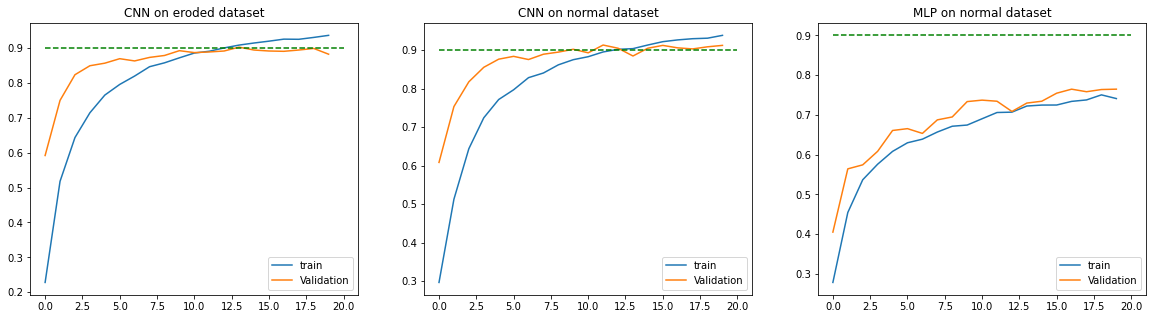

In [35]:

# plot the training and validation accuracy for both 3 models
fig = plt.figure(figsize=(20,5))

ax = fig.add_subplot(1,3,1)
ax.plot(erode_cnn_history.history['categorical_accuracy'], label='train')
ax.plot(erode_cnn_history.history['val_categorical_accuracy'], label='Validation')
ax.plot([0,20],[0.9,0.9], 'g--')
ax.legend()
ax.set_title("CNN on eroded dataset")

ax1 = fig.add_subplot(1,3,2)
ax1.plot(cnn_history.history['categorical_accuracy'], label='train')
ax1.plot(cnn_history.history['val_categorical_accuracy'], label='Validation')
ax1.plot([0,20],[0.9,0.9], 'g--')
ax1.legend()
ax1.set_title("CNN on normal dataset")


ax2 = fig.add_subplot(1,3,3)
ax2.plot(mlp_history.history['categorical_accuracy'], label='train')
ax2.plot(mlp_history.history['val_categorical_accuracy'], label='Validation')
ax2.plot([0,20],[0.9,0.9], 'g--')
ax2.legend()
ax2.set_title("MLP on normal dataset")
plt.show()

#### The analysis below was obtained from the three plots above:

### Erosion operation effect
applying erosion apparently did not help improve model performance. As seen from the left-most graph above, the model did not cross the green line (90%). On the other hand, the CNN model trained on non-eroded images crossed 90% and looks like it will do better with more epochs. However, when i ran the same test on less complex CNN models, i noticed that the model trained on eroded images converges faster.

With image this small, it is difficult to do morphological operations on it, which could be why erosion did not help here.

The best model is the CNN trained on non-eroded images dataset with a validation categorical accuracy slightly above 90%

### Spatial Information
Both CNNs seems to perform better than the MLP model althought the trainable parameters for all of them are almost equal ( 4.6M - 4.7M). This indicates that CNN architecture managed to capture the variation in the ways of writing characters due to its ability to capture spatial information. On the other hand, MLP was not able to capture such information causing to a decline in performance.

### Overfitting
There is a slight symptom of overfitting in both CNN models which starts around epoch 12 as the gap between training and validation accurcy starts to form. Hence, if this continues beyond 20 epoches there might be overfitting. 


Below i will plot the loss and validation loss for the three models 

Text(0.5, 1.0, 'MLP on normal dataset')

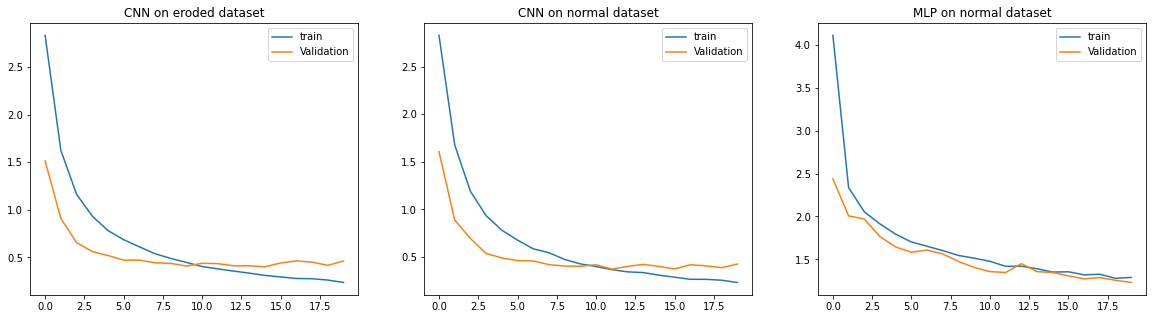

In [31]:
fig = plt.figure(figsize=(20,5))

ax = fig.add_subplot(1,3,1)
ax.plot(erode_cnn_history.history['loss'], label='train')
ax.plot(erode_cnn_history.history['val_loss'], label='Validation')
ax.legend()
ax.set_title("CNN on eroded dataset")

ax1 = fig.add_subplot(1,3,2)
ax1.plot(cnn_history.history['loss'], label='train')
ax1.plot(cnn_history.history['val_loss'], label='Validation')
ax1.legend()
ax1.set_title("CNN on normal dataset")


ax2 = fig.add_subplot(1,3,3)
ax2.plot(mlp_history.history['loss'], label='train')
ax2.plot(mlp_history.history['val_loss'], label='Validation')
ax2.legend()
ax2.set_title("MLP on normal dataset")

#### CNN on eroded data
The first 3 epochs show a significant reduction in loss, then followed by a slight increase at the end.

#### CNN on normal data
The first 3 epochs show a significant reduction in loss, followed by a slight fluctuation untill the end.

#### MLP on normal
There is a steady reduction from the beginning till the end.

-----
Below i will compare the validation accuracy for all 3 models

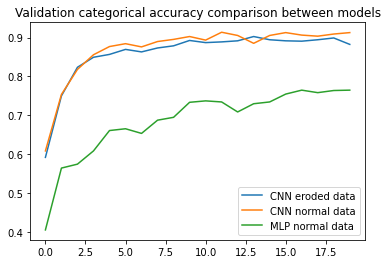

In [32]:
plt.title('Validation categorical accuracy comparison between models')
plt.plot(erode_cnn_history.history['val_categorical_accuracy'], label='CNN eroded data')
plt.plot(cnn_history.history['val_categorical_accuracy'], label='CNN normal data')
plt.plot(mlp_history.history['val_categorical_accuracy'], label='MLP normal data')
plt.legend(['CNN eroded data','CNN normal data','MLP normal data' ])
plt.show()

As you cans see from the graph above, both CNN models performed well with a slight favour to the CNN model trained on non-eroded images. The model with the worst performance is the MLP model trained on images without erosion.

# 9. Report the TypeI and TypeII errors of the developed model (Optional).
I will be using the best performing model to predict images in the testing dataframe, then Type1 and Type2 errors will be computed for each class

In [38]:
best_model = tf.keras.Sequential()
best_model.add(Conv2D(64, (5,5),input_shape=INPUT_SHAPE, activation='relu'))


best_model.add(Conv2D(64, (5,5), activation='relu'))


best_model.add(Flatten())

best_model.add(Dense(124, activation='relu'))
best_model.add(Dropout(0.3))

best_model.add(Dense(32, activation='relu', kernel_regularizer ='l2'))
best_model.add(Dropout(0.3))

best_model.add(Dense(N_CLASSES, activation='softmax'))




best_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)
best_model.summary()




Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 28, 28, 64)        1664      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 64)        102464    
_________________________________________________________________
flatten_5 (Flatten)          (None, 36864)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 124)               4571260   
_________________________________________________________________
dropout_12 (Dropout)         (None, 124)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)                4000      
_________________________________________________________________
dropout_13 (Dropout)         (None, 32)               

In [39]:
# loading the model weights saved by the checkpoint (best validation cat_accuracy)
best_model.load_weights("cnn_model_weights.h5")

In [40]:
def process(img):
    # return a normalized image
    return imread(img)/255.


In [41]:
# creating a feature of the predicted class
test_df['predicted'] = test_df['path'].apply(lambda p: np.argmax(best_model.predict(process(p).reshape(1,*INPUT_SHAPE))[0])+1)

In [42]:
# Displaying for example
test_df.head(2)

,id,class,path,predicted
0,897,1,Test Images 3360x32x32/Test/id_897_label_1.png,1
1,3250,1,Test Images 3360x32x32/Test/id_3250_label_1.png,1


Below i will construct a dataframe which contains Type1 and Type2 error for each class

In [43]:

# there arrays to hold the error types and classes
type1, type2, class_ = np.zeros((28),dtype='uint8'), np.zeros((28),dtype='uint8'), np.zeros((28),dtype='uint8')

# group by class and count Type 1 error (False negative)
for g_name, df in test_df.groupby('class'):
    type1[g_name-1] = df[df['predicted'] != df['class']].shape[0] 
    class_[g_name-1] = g_name

# group by prediction and count Type 2 error (False positive)
for g_name, df in test_df.groupby('predicted'):
    type2[g_name-1] = df[df['predicted'] != df['class']].shape[0]

# constructing a dataframe for easy plotting
result = pd.DataFrame({'typeI' : type1.tolist(),
                       'typeII' : type2.tolist(),
                       'class': class_.tolist()})

<AxesSubplot:xlabel='class'>

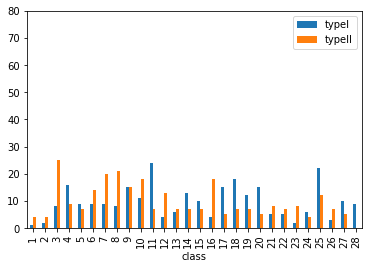

In [45]:
# plotting both types per each class
result.plot(x='class', kind='bar', ylim=(0,80)) # 0 - 80 because in total we have 80 samples per class

From the plot above, it appears that the model mistakes a lot of images with class 3 as the Type2 (False positive) error is the highest. Furthermore, the model seems to have difficulty recognizing class 11 and 25 the most as their Type1 (False negative) error are the highest.

Overall, the model manages to get at least 50 samples right from each class in the testing set.

# 10. Report the model results and suggest recommendations.


In [47]:

# loading images of test set to memory
X_test = np.array(test_df['path'].apply(lambda p: process(p).reshape(1,*INPUT_SHAPE)[0]).tolist())
# getting labels
y_test = pd.get_dummies(test_df['class']).to_numpy()

# evaluating the model using the test set
pred = best_model.evaluate(X_test, y_test)

70/70 [==============================] - 2s 26ms/step - loss: 0.4339 - categorical_accuracy: 0.8416


When used to perform prediction on the testing set, the model achieved %84.16 as can be seen from above.

Below, lets visualize some images and their predictions

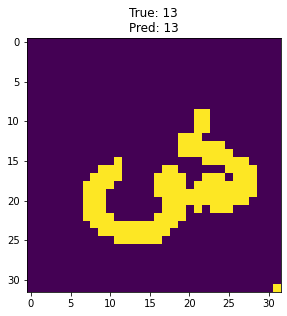

In [52]:
# reading an image 
image_idx = 999

# Get the predicted class from the model
prediction = np.argmax(best_model.predict(process(test_df['path'].iloc[image_idx]).reshape(1,*INPUT_SHAPE)))+1



# displaying the character
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(imread(test_df['path'].iloc[image_idx]))
ax1.set_title(f'True: {test_df["class"].iloc[image_idx]}\nPred: {prediction}')
plt.show()

## Suggestions and future works
* Need a larger images to run experiments regarding morphological operations effect on model performance.
* Experiment with more complex CNN architectures
* Try using Principle Component Analysis to reduce dimension
* Accomodate a more complex image augmentation (rotaion, slant, transformation...)
